# PyramidKV

In [1]:
import torch
import time
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

/home/sriney/miniconda3/envs/hawai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Configuration ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-large"
generation_length = 1024 # Let's test a longer sequence to see the memory savings

print(f"Using device: {device}")

# --- Load Model and Tokenizer (Clean, no overhead) ---
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
model.config.use_cache = True # Ensure caching is enabled

print("Setup complete.")

# --- VRAM Monitoring Helper Function ---
def get_vram_usage():
    """Returns the current GPU memory usage in GB."""
    if device == "cuda":
        return torch.cuda.memory_allocated(0) / (1024**3)
    return 0

Using device: cuda
Setup complete.


In [3]:
def analyze_inference_baseline(model, tokenizer):
    """
    Runs a true baseline test with a full KV cache.
    """
    print("\n--- Running test for strategy: 'TRUE BASELINE' ---")
    input_ids = torch.tensor([[tokenizer.bos_token_id]], dtype=torch.long).to(device)
    past_key_values = None
    timings = []
    vram_usage = []
    
    with torch.no_grad():
        for i in range(generation_length):
            start_time = time.perf_counter()
            outputs = model(input_ids=input_ids[:, -1:], past_key_values=past_key_values)
            next_token_id = torch.argmax(outputs.logits[:, -1, :], dim=-1).unsqueeze(-1)
            input_ids = torch.cat([input_ids, next_token_id], dim=-1)
            past_key_values = outputs.past_key_values
            end_time = time.perf_counter()
            
            timings.append((end_time - start_time) * 1000)
            vram_usage.append(get_vram_usage())
            
            if (i + 1) % 100 == 0:
                print(f"Generated {i + 1}/{generation_length} tokens...")
    
    print("'TRUE BASELINE' test complete.")
    return timings, vram_usage

def analyze_inference_pyramidkv(model, tokenizer, ratios):
    """
    Runs an inference test using the PyramidKV strategy.
    """
    print("\n--- Running test for strategy: 'PyramidKV' ---")
    num_layers = model.config.num_hidden_layers
    
    def trim_cache_pyramidkv(pkv, ratios):
        """Trims the KV cache according to the pyramid ratios."""
        new_pkv = []
        full_cache_size = pkv[0][0].shape[2]
        
        # Determine the cache size for each layer based on its position
        for i, layer_past in enumerate(pkv):
            layer_ratio_index = int((i / num_layers) * len(ratios))
            ratio = ratios[layer_ratio_index]
            
            keep_size = max(1, int(full_cache_size * ratio)) # Ensure at least 1 token is kept
            
            if full_cache_size > keep_size:
                # Keep the most recent 'keep_size' tokens for this layer
                kept_keys = layer_past[0][:, :, -keep_size:]
                kept_values = layer_past[1][:, :, -keep_size:]
                new_pkv.append((kept_keys, kept_values))
            else:
                new_pkv.append(layer_past) # No trimming needed yet
                
        return tuple(new_pkv)

    input_ids = torch.tensor([[tokenizer.bos_token_id]], dtype=torch.long).to(device)
    past_key_values = None
    timings = []
    vram_usage = []

    with torch.no_grad():
        for i in range(generation_length):
            start_time = time.perf_counter()
            outputs = model(input_ids=input_ids[:, -1:], past_key_values=past_key_values)
            
            # Get the new KV cache
            pkv = outputs.past_key_values
            
            # Trim the cache using the PyramidKV logic
            if pkv is not None:
                past_key_values = trim_cache_pyramidkv(pkv, ratios)
            
            next_token_id = torch.argmax(outputs.logits[:, -1, :], dim=-1).unsqueeze(-1)
            input_ids = torch.cat([input_ids, next_token_id], dim=-1)
            end_time = time.perf_counter()

            timings.append((end_time - start_time) * 1000)
            vram_usage.append(get_vram_usage())
            
            if (i + 1) % 100 == 0:
                print(f"Generated {i + 1}/{generation_length} tokens...")
                
    print("'PyramidKV' test complete.")
    return timings, vram_usage

In [4]:
# --- Define the PyramidKV Strategy ---
# This means:
# - First 50% of layers: Keep 100% of the cache
# - Next 25% of layers: Keep 50% of the cache
# - Final 25% of layers: Keep 25% of the cache
pyramid_ratios = [1.0] * 2 + [0.5] * 1 + [0.25] * 1

# --- Run the Two Experiments ---
baseline_timings, baseline_vram = analyze_inference_baseline(model, tokenizer)
pyramid_timings, pyramid_vram = analyze_inference_pyramidkv(model, tokenizer, ratios=pyramid_ratios)



--- Running test for strategy: 'TRUE BASELINE' ---
Generated 100/1024 tokens...
Generated 200/1024 tokens...
Generated 300/1024 tokens...
Generated 400/1024 tokens...
Generated 500/1024 tokens...
Generated 600/1024 tokens...
Generated 700/1024 tokens...
Generated 800/1024 tokens...
Generated 900/1024 tokens...
Generated 1000/1024 tokens...
'TRUE BASELINE' test complete.

--- Running test for strategy: 'PyramidKV' ---


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.53.0. You should pass an instance of `Cache` instead, e.g. `past_key_values=DynamicCache.from_legacy_cache(past_key_values)`.


Generated 100/1024 tokens...
Generated 200/1024 tokens...
Generated 300/1024 tokens...
Generated 400/1024 tokens...
Generated 500/1024 tokens...
Generated 600/1024 tokens...
Generated 700/1024 tokens...
Generated 800/1024 tokens...
Generated 900/1024 tokens...
Generated 1000/1024 tokens...
'PyramidKV' test complete.


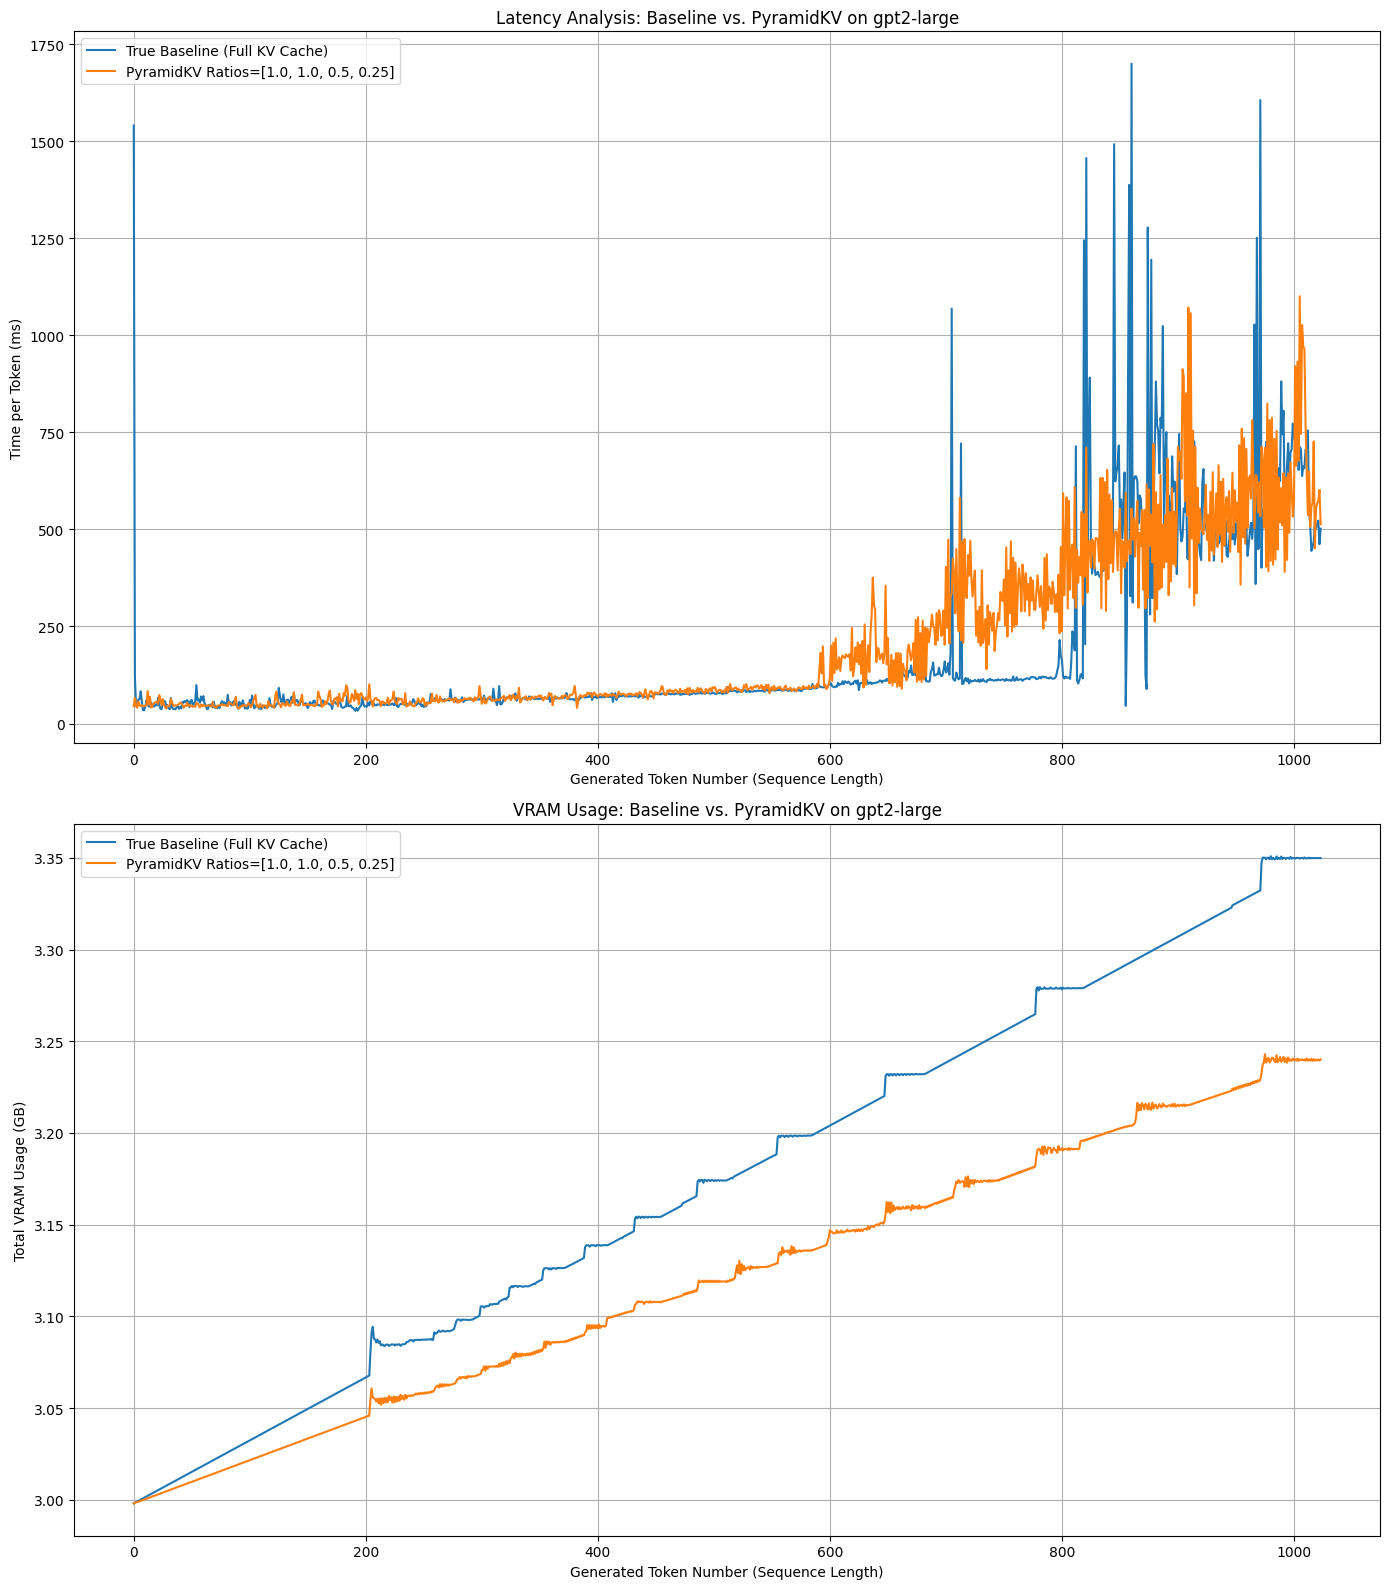

In [5]:
# --- Create the Plots ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

# Plot 1: Latency (Time per Token)
ax1.plot(baseline_timings, label='True Baseline (Full KV Cache)')
ax1.plot(pyramid_timings, label=f'PyramidKV Ratios={pyramid_ratios}')
ax1.set_xlabel('Generated Token Number (Sequence Length)')
ax1.set_ylabel('Time per Token (ms)')
ax1.set_title(f'Latency Analysis: Baseline vs. PyramidKV on {model_name}')
ax1.legend()
ax1.grid(True)

# Plot 2: VRAM Usage
ax2.plot(baseline_vram, label='True Baseline (Full KV Cache)')
ax2.plot(pyramid_vram, label=f'PyramidKV Ratios={pyramid_ratios}')
ax2.set_xlabel('Generated Token Number (Sequence Length)')
ax2.set_ylabel('Total VRAM Usage (GB)')
ax2.set_title(f'VRAM Usage: Baseline vs. PyramidKV on {model_name}')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()